In [1]:
import os
import json
import csv
import pandas as pd
import numpy as np

<h3>Preprocess the data</h3>

ingest json and extract type of establsishment data, flatten to data frame

In [2]:
os.chdir('D:/in/cv/pmit/UseCase_3_Datasets/')

with open('Surroundings.json', 'r') as f:
    j = json.load(f)

d = []

for i in j:
    s = i['surroundings']
    for k, v in s.items():
        if len(v) > 0:
            for x in v:
                d.append([i['store_code'], k, x['place_id'], x['name']])

data = pd.DataFrame(d, columns=['store_code','type','id','name'])                

recode values to reduce dimensionality and produce easily interpretable predictors

In [3]:
recode = {
 'accounting':'finance',
 'airport':'transport',
 'amusement_park':'entertainment',
 'aquarium':'recreational',
 'art_gallery':'culture',
 'atm':'finance',
 'bakery':'catering',
 'bank':'finance',
 'bar':'catering',
 'beauty_salon':'services',
 'bicycle_store':'retail',
 'book_store':'retail',
 'bowling_alley':'entertainment',
 'bus_station':'transport',
 'cafe':'catering',
 'campground':'recreational',
 'car_dealer':'automotive',
 'car_rental':'automotive',
 'car_repair':'automotive',
 'car_wash':'automotive',
 'casino':'entertainment',
 'cemetery':'ritual',
 'church':'ritual',
 'city_hall':'governmental',
 'clothing_store':'retail',
 'convenience_store':'retail',
 'courthouse':'governmental',
 'dentist':'medical',
 'department_store':'retail',
 'doctor':'medical',
 'electrician':'services',
 'electronics_store':'retail',
 'embassy':'governmental',
 'fire_station':'governmental',
 'florist':'retail',
 'funeral_home':'ritual',
 'furniture_store':'retail',
 'gas_station':'automotive',
 'gym':'recreational',
 'hair_care':'services',
 'hardware_store':'retail',
 'home_goods_store':'retail',
 'hospital':'medical',
 'insurance_agency':'finance',
 'jewelry_store':'retail',
 'laundry':'services',
 'lawyer':'services',
 'library':'culture',
 'liquor_store':'retail',
 'local_government_office':'governmental',
 'locksmith':'services',
 'lodging':'lodging',
 'meal_delivery':'catering',
 'meal_takeaway':'catering',
 'mosque':'retail',
 'movie_rental':'entertainment',
 'movie_theater':'entertainment',
 'moving_company':'services',
 'museum':'culture',
 'night_club':'entertainment',
 'painter':'services',
 'park':'recreational',
 'parking':'automotive',
 'pet_store':'retail',
 'pharmacy':'medical',
 'physiotherapist':'medical',
 'plumber':'services',
 'police':'governmental',
 'post_office':'governmental',
 'real_estate_agency':'services',
 'restaurant':'catering',
 'roofing_contractor':'services',
 'shoe_store':'retail',
 'shopping_mall':'retail',
 'spa':'recreational',
 'stadium':'entertainment',
 'storage':'services',
 'store':'retail',
 'subway_station':'transport',
 'synagogue':'ritual',
 'taxi_stand':'transport',
 'train_station':'transport',
 'transit_station':'transport',
 'travel_agency':'services',
 'university':'culture',
 'veterinary_care':'services',
 'zoo':'recreational'}
data['category']=data['type']
data['category'].replace(recode, inplace=True)

deduplicate

In [4]:
data = data.drop_duplicates(['store_code','id'])

aggregate the data by store code and category of establishment, summarize the number of establishments by category

In [6]:
data_a1 = data[['store_code','category']].copy()
data_a1['n'] = 1

data_a2 = data_a1.groupby(['store_code','category']).sum().unstack()
data_a2 = data_a2.fillna(0)

data_a2.columns = data_a2.columns.droplevel()
data_a2.reset_index(inplace=True)

get number of establishments, aggregate by store code 

In [8]:
d_total = data_a1.groupby(['store_code']).sum().reset_index()
d_total.columns = ['store_code','total number of establishments']

ingest sales data

In [9]:
sales = pd.read_csv('sales_granular.csv')
ss = sales.melt(id_vars='store_code',var_name='time',value_name='vol')
ss['time'] = pd.to_datetime(ss['time'], format='%m/%d/%y %H:%M')
ss['date'] = ss['time'].dt.date

aggregate sales data by date

In [13]:
ss = ss[['store_code','date','vol']]
ss1 = ss.groupby(['store_code','date']).sum()
ss1 = ss1.loc[ss1['vol'] > 0]

aggregate and create target variable - <b>average daily sales volume</b> (averaging only across days with sales data available)

In [14]:
ss2 = ss1.groupby(['store_code']).mean()
ss2 = ss2.reset_index()

filter out outliers by MAD*3

In [27]:
print(f'Mean Absolute Deviation for sales volume:  {ss2.vol.mad():03.1f}')
sales_clean = ss2[ss2.vol <= 3*ss2.vol.mad()]

Mean Absolute Deviation for sales volume:  199.4


merge datasets to ensure data integrity

In [28]:
data_clean = pd.merge(data_a2,d_total,on='store_code',how='inner')
fullset = pd.merge(sales_clean,data_clean,on='store_code',how='inner')

<h3>Random Forest</h3>

In [29]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split as tts

create train and test (20%) datasets

In [32]:
train, test = tts(fullset, test_size=0.2,random_state=123)

make datasets with predictors and target on training data

In [33]:
X = train.drop(['store_code','vol',],axis=1)
Y = train['vol']

train the model

In [39]:
rf = RFR(1000, oob_score=True,random_state=104).fit(X, Y)

output feature importance table

In [40]:
imps = pd.DataFrame(np.round_(rf.feature_importances_*100,1),X.columns.values).reset_index() 
imps.columns=['feature','importance']
imps.sort_values(by='importance',ascending=False)

,feature,importance
7,medical,12.1
2,culture,11.8
0,automotive,10.1
1,catering,9.1
13,total number of establishments,8.9
9,retail,8.6
12,transport,7.0
4,finance,6.9
10,ritual,5.5
5,governmental,5.1


make datasets with predictors and target on test data

In [50]:
X = test.drop(['store_code','vol'],axis=1)
Y = test['vol']

predict values using model

In [42]:
predicted = rf.predict(X)

measure model fit

In [43]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

test_score = r2_score(Y, predicted)
spearman = spearmanr(Y, predicted)
pearson = pearsonr(Y, predicted)

print(f'Out-of-bag R\u00b2 estimate: {rf.oob_score_:>5.3}')
print(f'R\u00b2 score: {test_score:>5.3}')
print(f'Spearman coef.: {spearman[0]:.3}')
print(f'Pearson coef.: {pearson[0]:.3}')

Out-of-bag R² estimate: -0.211
R² score:  0.84
Spearman coef.: 0.893
Pearson coef.: 0.969


plot model fit

Text(0,0.5,'predicted')

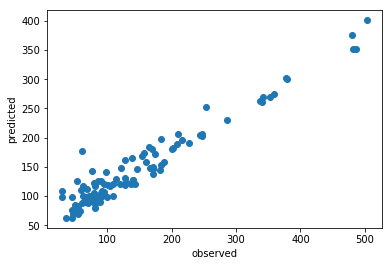

In [49]:
import matplotlib.pyplot as plt
plt.scatter(Y,predicted)
plt.xlabel('observed')
plt.ylabel('predicted')